In [461]:
from datetime import datetime
import collections
import csv
import itertools
import logging
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')

from fitter import Fitter
import igraph as ig
from igraph import Graph
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
# 配置
plt.rcParams['figure.figsize'] = (10,10)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
sns.set_style('white', {'font.family':'serif', 'font.serif':'Times New Roman'})

# mcolors.BASE_COLORS
# mcolors.CSS4_COLORS
# mcolors.TABLEAU_COLORS
colors = list(mcolors.TABLEAU_COLORS.values())
unfilled_markers = [m for m, func in Line2D.markers.items()
                    if func != 'nothing' and m not in Line2D.filled_markers]
linestyle_tuple = [
     ('loosely dotted',        (0, (1, 10))),
     ('dotted',                (0, (1, 1))),
     ('densely dotted',        (0, (1, 1))),

     ('loosely dashed',        (0, (5, 10))),
     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

     ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

In [6]:
def beauty_print(datas: list, placeholder_len=3):
    '''
    
    Parmas:
    ------
    datas: list
        First row of the datas is the header
    
    '''
    df = pd.DataFrame(datas)
    col_len = [max(map(lambda x: len(str(x)), df[label]))+placeholder_len for label in df.columns]
    tr = '+'+'+'.join(['-'*i for i in col_len])+'+'
    th = ('|'+'|'.join(['{{:<{}}}'.format(i) for i in col_len])+'|').format(*datas[0])
    print(tr)
    print(th)
    print(tr)
    for row in datas[1:]:
        print(('|'+'|'.join(['{{:<{}}}'.format(i) for i in col_len])+'|').format(*row))
    print(tr)

# Load Data

## for imnet 5 mice

In [552]:
ERR_paths = Path('/home/jiewen.du/software/mixcr-3.0.13/reports')
report_fs = sorted(ERR_paths.glob('*clonotypes*'))

In [558]:
dfs_imnet[3].shape

(616100, 35)

In [2]:
# load gml file to memory
root = Path('/data/ab01/to_dujiewen/gml')
index_labels = [f'CM00{i}_train' for i in range(6)]
index_labels.extend([f'CM00{i}_valid' for i in range(1, 6)])
gs = [Graph.Load(root/f'{label}.gml', format='gml') for label in index_labels]

# update edge attribute {'weight'}: from str to int
for g in gs:
    for e in g.es:
        e['weight'] = int(e['weight'])

In [549]:
gs[0].write('test.gml', format='gml')

In [545]:
cm004_t = gs[4].decompose()

## 中心性指标
1. https://zhuanlan.zhihu.com/p/354736458
2. https://blog.csdn.net/myy3075/article/details/87948777

1. 度中心性（Degree Centrality）：度中心性测量网络中一个节点与所有其它节点相联系的程度。在无向图（Undirected Graph）中，度中心性测量网络中一个节点与所有其它节点直接相连的程度。网络规模越大，度中心性的最大可能值就越高。
2. 接近中心性（Closeness Centrality）：接近中心性反映在网络中某一节点与其他节点之间的接近程度。不同于度中心性考虑直接相连的情况，接近中心性需要考量每个结点到其它结点的最短路径的平均长度。也就是说，对于一个结点而言，它距离其它结点越近，那么它的中心度越高。

## Centrality VS Centralization
Reference: http://www.analytictech.com/mb119/chapter5.htm

# Global parameters

## A. Network size

In [8]:
# Global parameters
cols_A = ['diameter', 'assortativity', 'density', 'transitivity']

def cmp_global_params(g):
    '''
    
    Returns:
    -------
    nodes: int
    edges: int
    diameter: int
    density: float
    assortativity: float
    coreness: list
    
    '''
    # nodes = g.vcount()
    # edges = g.ecount()
    
    diameter = g.diameter(directed=False, unconn=True, weights=None)
    assortativity = g.assortativity_degree(directed=False)
    density = g.density()
    transitivity = g.transitivity_undirected()
    
    return [diameter, assortativity, density, transitivity]

network_sizes = []
for g in gs:
    network_sizes.append(cmp_global_params(g))
    
network_size_data = [cols_A]+network_sizes
beauty_print(network_size_data)

+-----------+-----------------------+---------------------+
|diameter   |assortativity          |density              |
+-----------+-----------------------+---------------------+
|3          |0.07703954355551221    |0.6830985915492959   |
|3          |0.10255043314032962    |0.596701625245289    |
|4          |0.017152448763681483   |0.549537105868548    |
|3          |0.08641829396722621    |0.6235377486141218   |
|4          |0.11248568213717093    |0.6167061498158091   |
|3          |0.05500426982269461    |0.5733544805709754   |
|3          |0.17055842181315495    |0.7451181911613566   |
|3          |0.024060199730925807   |0.590158859155202    |
|3          |0.04902421155812869    |0.6825086198863106   |
|3          |0.11993586102116889    |0.6768778123918311   |
|1          |nan                    |1.0                  |
+-----------+-----------------------+---------------------+


In [10]:
df_network_size = pd.DataFrame(network_sizes, columns=cols_A)
df_network_size['source'] = index_labels
df_network_size = df_network_size.loc[:, ['source', *df_network_size.columns[:-1]]]
df_network_size

source  diameter  assortativity   density
0   CM000_train         3       0.077040  0.683099
1   CM001_train         3       0.102550  0.596702
2   CM002_train         4       0.017152  0.549537
3   CM003_train         3       0.086418  0.623538
4   CM004_train         4       0.112486  0.616706
5   CM005_train         3       0.055004  0.573354
6   CM001_valid         3       0.170558  0.745118
7   CM002_valid         3       0.024060  0.590159
8   CM003_valid         3       0.049024  0.682509
9   CM004_valid         3       0.119936  0.676878
10  CM005_valid         1            NaN  1.000000

In [11]:
df_1 = pd.read_csv('imnet_params/network_size.tsv', sep='\t')
df_2 = pd.merge(df_1, df_network_size, on='source')
df_2

source  nodes   edges  component_cnt  largest_component_size  \
0   CM000_train    213   15423              1                     213   
1   CM001_train   1460  635529              1                    1460   
2   CM002_train   1119  343747              1                    1119   
3   CM003_train   1467  670497              3                    1465   
4   CM004_train   1618  806746              2                    1611   
5   CM005_train    195   10845              2                     194   
6   CM001_valid    140    7250              1                     140   
7   CM002_valid    322   30500              1                     322   
8   CM003_valid    147    7324              1                     147   
9   CM004_valid    108    3911              2                     106   
10  CM005_valid      5      10              1                       5   

    perc_giant_component  diameter  assortativity   density  
0                 1.0000         3       0.077040  0.683099  
1                 1.0000         3       0.102550  0.596702  
2                 1.0000         4       0.017152  0.549537  
3                 0.9986         3       0.086418  0.623538  
4                 0.9957         4       0.112486  0.616706  
5                 0.9949         3       0.055004  0.573354  
6                 1.0000         3       0.170558  0.745118  
7                 1.0000         3       0.024060  0.590159  
8                 1.0000         3       0.049024  0.682509  
9                 0.9815         3       0.119936  0.676878  
10                1.0000         1            NaN  1.000000

In [ ]:
# # Clonal level parameters
# clos_B = ['degree','transitivity','authority','closeness','betweenness','pagerank']

# def cmp_clonal_params(g):
#     '''
#     Parmas:
#     ------
#     graph: graph
#         A networkx graph.
    
#     Returns:
#     ------
#     authority: list
#         Kleinberg's authority score for the vertices of the graph
#     degree_centrality: nodes dictionary
#         Dictionary of nodes with degree centrality as the value.
#     eigenvector_centrality: nodes dictionary
#         Dictionary of nodes with eigenvector centrality as the value. 
#     closeness_centrality: nodes dictionary
#         Dictionary of nodes with closeness centrality as the value.
#     betweenness_centrality: nodes dictionary
#         Dictionary of nodes with betweenness centrality as the value. BC distribution follows a power-law p(g) ∼ g−η for scale-free networks
#     PageRank: pagerank dictionary
#         Dictionary of nodes with PageRank as value. 
        
#     transitivity: float
#     '''
    
#     # Centrality
#     eigenvector_centrality = g.eigenvector_centrality(directed=False, scale=True, weights=None)
#     PageRank = g.personalized_pagerank()
#     closeness = g.closeness(normalized=True)
#     betweenness = g.betweenness(directed=False)

# Clonal params

In [326]:
unweighted_clonal_params = dict()
for source, g in zip(index_labels, gs):
    unweighted_clonal_params[source] = dict()
    unweighted_clonal_params[source]['authority'] = g.authority_score(scale=True)
    unweighted_clonal_params[source]['eigenvector'] = g.eigenvector_centrality(directed=False, scale=True)
    unweighted_clonal_params[source]['pagerank'] = g.personalized_pagerank()
    unweighted_clonal_params[source]['closeness'] = g.closeness(normalized=True)
    unweighted_clonal_params[source]['betweenness']  = g.betweenness(directed=False)
    unweighted_clonal_params[source]['coreness'] = g.coreness(mode='all')

fw = open('imnet_params/unweighted_clonal_params.pkl','wb')
pickle.dump(unweighted_clonal_params, fw)
fw.close()

weighted_clonal_params = dict()
for source, g in zip(index_labels, gs):
    weighted_clonal_params[source] = dict()
    weighted_clonal_params[source]['authority'] = g.authority_score(weights='weight', scale=True)
    weighted_clonal_params[source]['eigenvector'] = g.eigenvector_centrality(directed=False, weights='weight', scale=True)
    weighted_clonal_params[source]['pagerank'] = g.personalized_pagerank(weights='weight')
    weighted_clonal_params[source]['closeness'] = g.closeness(weights='weight', normalized=True)
    weighted_clonal_params[source]['betweenness']  = g.betweenness(directed=False, weights='weight')
    weighted_clonal_params[source]['coreness'] = g.coreness(mode='all')

fw2 = open('imnet_params/weighted_clonal_params.pkl','wb')
pickle.dump(weighted_clonal_params, fw2)
fw2.close()

## Plot of Clonal params

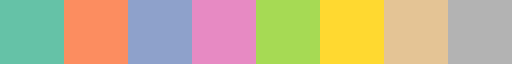

In [393]:
from matplotlib import cm
cm.get_cmap('Set2')

In [410]:
cm.get_cmap('Set2').colors

((0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254))

In [386]:
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors

# mcolors.BASE_COLORS
# mcolors.CSS4_COLORS
# mcolors.TABLEAU_COLORS

colors = list(mcolors.TABLEAU_COLORS.values())
unfilled_markers = [m for m, func in Line2D.markers.items()
                    if func != 'nothing' and m not in Line2D.filled_markers]
linestyle_tuple = [
     ('loosely dotted',        (0, (1, 10))),
     ('dotted',                (0, (1, 1))),
     ('densely dotted',        (0, (1, 1))),

     ('loosely dashed',        (0, (5, 10))),
     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

     ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

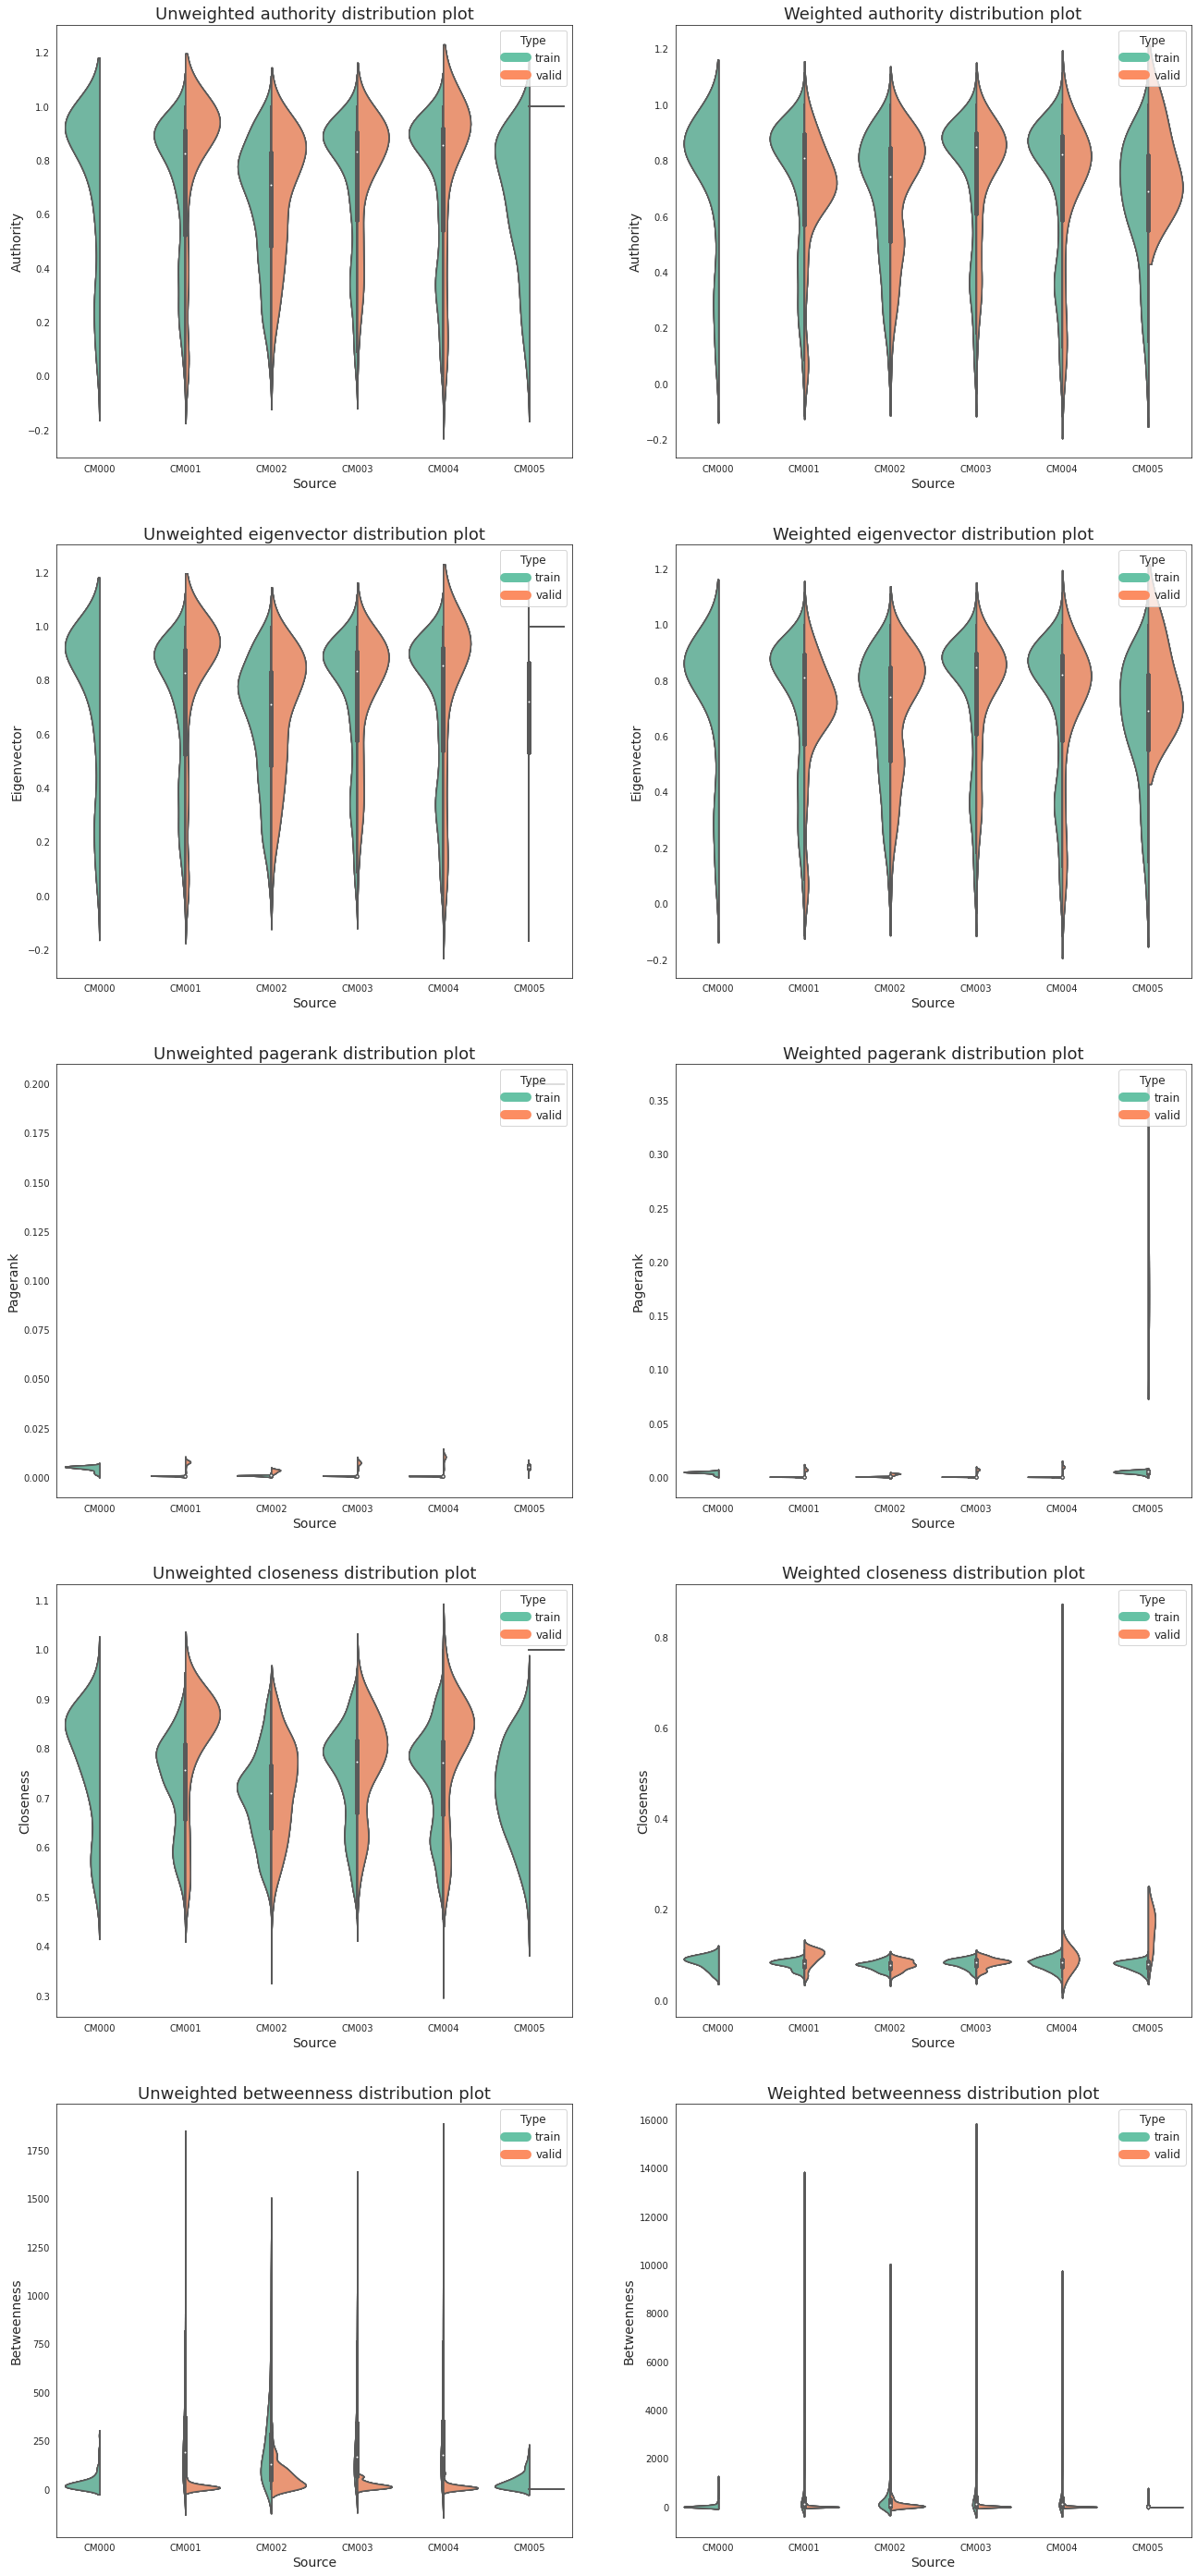

In [430]:
# clonal_params
clonal_param_names = ['authority', 'eigenvector', 'pagerank', 'closeness', 'betweenness']

temp_data_weighted = []
for source, params in weighted_clonal_params.items():
    sub_data = []
    for param_name in clonal_param_names:
        sub_data.append(params[param_name])
    sub_data = np.array(sub_data)
    source, datatype = source.split('_')
    for iloc in range(sub_data.shape[1]):
        temp_data_weighted.append([source, datatype, *sub_data[:, iloc]])
df_temp_weighted = pd.DataFrame(temp_data_weighted, columns=['source', 'datatype', *clonal_param_names]) # shape: len(g.nodes)*g_cnt

temp_data_unweighted = []
for source, params in unweighted_clonal_params.items():
    sub_data = []
    for param_name in clonal_param_names:
        sub_data.append(params[param_name])
    sub_data = np.array(sub_data)
    source, datatype = source.split('_')
    for iloc in range(sub_data.shape[1]):
        temp_data_unweighted.append([source, datatype, *sub_data[:, iloc]])
df_temp_unweighted = pd.DataFrame(temp_data_unweighted, columns=['source', 'datatype', *clonal_param_names])

fig, axes = plt.subplots(5, 2, figsize=(22, 50))
custom_lines = [Line2D([0], [0], color=cm.get_cmap('Set2').colors[x], ls='solid', lw=10) for x in [0,1]]
for row in range(0,5):
    for col in range(0,2):
        if col==0:
            for x in [f'CM00{x}' for x in range(0,6)]:
                sns.violinplot(
                    data=df_temp_unweighted,
                    x='source',
                    y=clonal_param_names[row],
                    hue='datatype',
                    palette='Set2',
                    split=True,
                    ax=axes[row][col]
                )
            axes[row][col].set_xlabel('Source', fontsize=14)
            axes[row][col].set_ylabel(clonal_param_names[row].capitalize(), fontsize=14)
            axes[row][col].legend(handles=custom_lines, labels=['train', 'valid'], title='Type', loc='upper right', fontsize='large', title_fontsize='large')
            axes[row][col].set_title(f'Unweighted {clonal_param_names[row]} distribution plot',fontsize=18)
        else:
            for x in [f'CM00{x}' for x in range(0,6)]:
                sns.violinplot(
                    data=df_temp_weighted,
                    x='source',
                    y=clonal_param_names[row],
                    hue='datatype',
                    palette='Set2',
                    split=True,
                    ax=axes[row][col]
                )
            axes[row][col].set_xlabel('Source', fontsize=14)
            axes[row][col].set_ylabel(clonal_param_names[row].capitalize(), fontsize=14)
            axes[row][col].legend(handles=custom_lines, labels=['train', 'valid'], title='Type', loc='upper right', fontsize='large', title_fontsize='large')
            axes[row][col].set_title(f'Weighted {clonal_param_names[row]} distribution plot',fontsize=18)

plt.savefig(f'./plot/local_params.png', format='png', transparent=True, bbox_inches='tight')
plt.show()

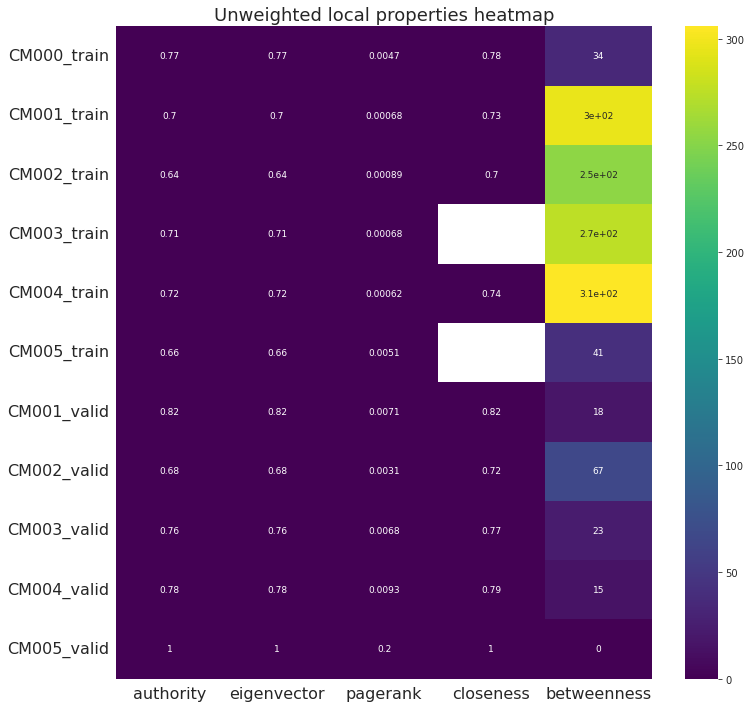

In [446]:
# heatmap
plt.figure(figsize=(12, 12))
temp_data = []
for source, params in unweighted_clonal_params.items():
    means = []
    for param_name in clonal_param_names:
        means.append(np.mean(params[param_name]))
    temp_data.append([source, *means])
df_mean_heatmap = pd.DataFrame(temp_data, columns=['Source', *clonal_param_names])

ax = sns.heatmap(df_mean_heatmap.iloc[:, 1:], annot=True, annot_kws={"size": 9}, cmap='viridis')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
ax.set_yticklabels(index_labels, fontsize=16, rotation=0)
ax.set_title(f'Unweighted local properties heatmap',fontsize=18)
plt.savefig(f'./plot/local_params_heatmap_unweighted.png', format='png', transparent=True, bbox_inches='tight')
plt.show()

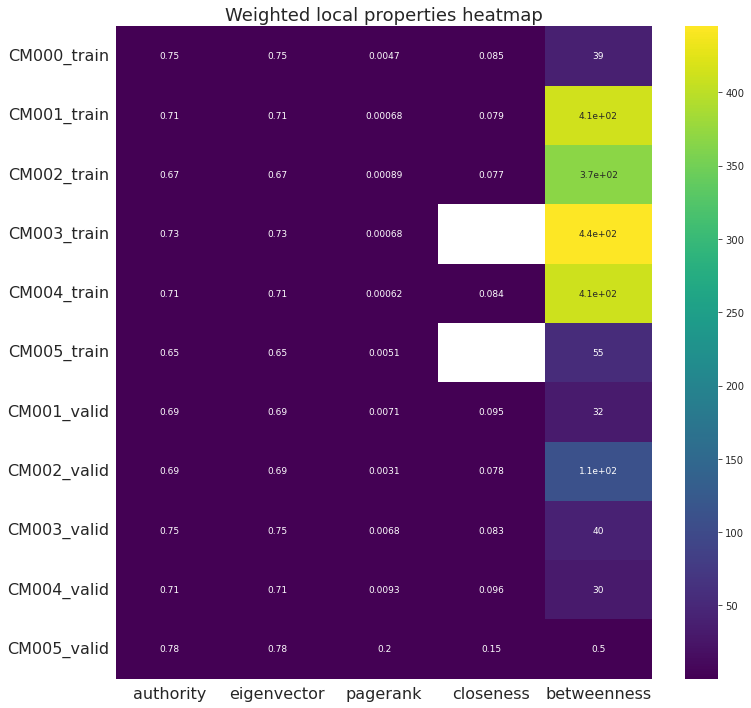

In [447]:
# heatmap
plt.figure(figsize=(12, 12))
temp_data = []
for source, params in weighted_clonal_params.items():
    means = []
    for param_name in clonal_param_names:
        means.append(np.mean(params[param_name]))
    temp_data.append([source, *means])
df_mean_heatmap = pd.DataFrame(temp_data, columns=['Source', *clonal_param_names])

ax = sns.heatmap(df_mean_heatmap.iloc[:, 1:], annot=True, annot_kws={"size": 9}, cmap='viridis')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
ax.set_yticklabels(index_labels, fontsize=16, rotation=0)
ax.set_title(f'Weighted local properties heatmap',fontsize=18)
plt.savefig(f'./plot/local_params_heatmap_weighted.png', format='png', transparent=True, bbox_inches='tight')
plt.show()

# The structure of antibody repertoires
## A. similar clones

In [27]:
# find similar clones, from LD1 ... to LD12
similar_clones = []
for g in gs:
    node_sets = [set() for i in range(12)]
    for e in g.es:
        node_sets[int(e['weight'])-1].add(e.source)
        node_sets[int(e['weight'])-1].add(e.target)
    similar_clones.append(list(map(len, node_sets)))

In [28]:
similar_clones

[[44, 33, 37, 69, 101, 138, 174, 194, 207, 211, 213, 213],
 [702, 605, 545, 722, 977, 1226, 1362, 1428, 1451, 1455, 1460, 1460],
 [568, 545, 516, 599, 740, 880, 998, 1075, 1104, 1113, 1119, 1119],
 [731, 725, 750, 878, 1087, 1241, 1339, 1416, 1450, 1461, 1463, 1465],
 [537, 562, 654, 963, 1208, 1397, 1513, 1568, 1597, 1607, 1609, 1611],
 [83, 78, 64, 67, 66, 100, 142, 157, 184, 190, 194, 194],
 [73, 66, 60, 67, 85, 107, 119, 130, 131, 139, 140, 140],
 [205, 190, 182, 173, 190, 218, 266, 294, 318, 319, 322, 322],
 [82, 72, 72, 46, 28, 55, 95, 127, 139, 146, 147, 147],
 [70, 67, 37, 47, 58, 60, 78, 96, 98, 106, 106, 106],
 [3, 2, 0, 0, 0, 0, 0, 4, 2, 2, 2, 2]]

In [33]:
df_similar_clones = pd.DataFrame(similar_clones, columns=[f'LD{i}' for i in range(1,13)])
df_3 = pd.concat([df_2, df_similar_clones], axis=1)
df_3

source  nodes   edges  component_cnt  largest_component_size  \
0   CM000_train    213   15423              1                     213   
1   CM001_train   1460  635529              1                    1460   
2   CM002_train   1119  343747              1                    1119   
3   CM003_train   1467  670497              3                    1465   
4   CM004_train   1618  806746              2                    1611   
5   CM005_train    195   10845              2                     194   
6   CM001_valid    140    7250              1                     140   
7   CM002_valid    322   30500              1                     322   
8   CM003_valid    147    7324              1                     147   
9   CM004_valid    108    3911              2                     106   
10  CM005_valid      5      10              1                       5   

    perc_giant_component  diameter  assortativity   density  LD1  ...  LD3  \
0                 1.0000         3       0.077040  0.683099   44  ...   37   
1                 1.0000         3       0.102550  0.596702  702  ...  545   
2                 1.0000         4       0.017152  0.549537  568  ...  516   
3                 0.9986         3       0.086418  0.623538  731  ...  750   
4                 0.9957         4       0.112486  0.616706  537  ...  654   
5                 0.9949         3       0.055004  0.573354   83  ...   64   
6                 1.0000         3       0.170558  0.745118   73  ...   60   
7                 1.0000         3       0.024060  0.590159  205  ...  182   
8                 1.0000         3       0.049024  0.682509   82  ...   72   
9                 0.9815         3       0.119936  0.676878   70  ...   37   
10                1.0000         1            NaN  1.000000    3  ...    0   

    LD4   LD5   LD6   LD7   LD8   LD9  LD10  LD11  LD12  
0    69   101   138   174   194   207   211   213   213  
1   722   977  1226  1362  1428  1451  1455  1460  1460  
2   599   740   880   998  1075  1104  1113  1119  1119  
3   878  1087  1241  1339  1416  1450  1461  1463  1465  
4   963  1208  1397  1513  1568  1597  1607  1609  1611  
5    67    66   100   142   157   184   190   194   194  
6    67    85   107   119   130   131   139   140   140  
7   173   190   218   266   294   318   319   322   322  
8    46    28    55    95   127   139   146   147   147  
9    47    58    60    78    96    98   106   106   106  
10    0     0     0     0     4     2     2     2     2  

[11 rows x 21 columns]

In [41]:
for i in range(1, 13):
    df_3[f'X{i}'] = df_3[f'LD{i}']/df_3['nodes']
df_3.drop(columns=[f'LD{i}' for i in range(1,13)], inplace=True)
df_3.columns[9:-1]

## Plot of similar clones

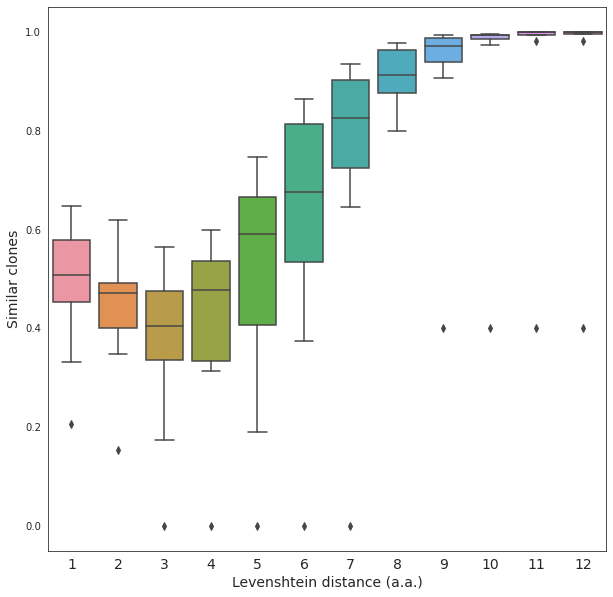

In [274]:
plt.figure(figsize=(10, 10))

ax = sns.boxplot(data=df_3.iloc[:,9:-1])

ax.set_xticklabels([f'{i}' for i in range(1,13)], fontsize=14)
# ax.set_yticklabels(list(range(0, 120, 20)), fontsize=14)

ax.set_xlabel('Levenshtein distance (a.a.)', fontsize=14)
ax.set_ylabel('Similar clones', fontsize=14)
# ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.savefig("./plot/similar_clones.png", format='png', transparent=True, bbox_inches='tight')
plt.show()

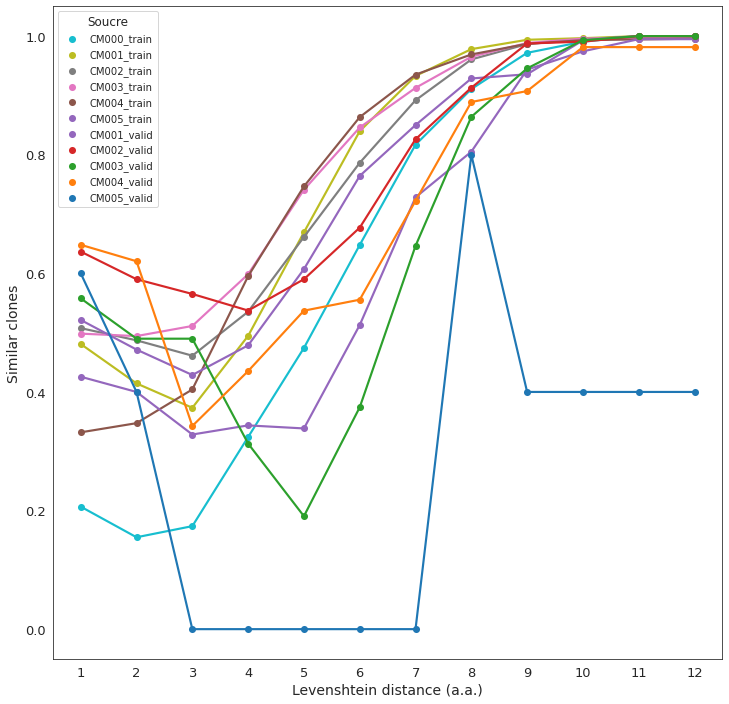

In [280]:
plt.figure(figsize=(12, 12))
temp_datas = []
for row in df_3.loc[:, ['source', *[f'X{i}' for i in range(1,13)]]].itertuples(False):
    for i in range(1,13):
        temp_datas.append([row[0], f'{i}', row[i]])
        
plot_df = pd.DataFrame(temp_datas,columns=['Source', 'LD', 'similar_clones'])
ax = sns.pointplot(data=plot_df, x='LD', y='similar_clones', hue='Source', palette='tab10_r', scale=0.8)
ax.set_xlabel('Levenshtein distance (a.a.)', fontsize=14)
ax.set_ylabel('Similar clones', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(title='Soucre', title_fontsize='large')
plt.savefig("./plot/similar_clone_distribution.png", format='png', bbox_inches='tight')
plt.show()

## average neighborhood size

In [46]:
# find average neighborhood size
orders = list(range(1, 11)) + [15, 20,30,40,50]

neighborhood_size = []
for g in gs:
    nbs_in_order = []
    for order in orders:
        nbs_in_order.append(g.neighborhood_size(order=order))
        # average_nb = sum(nbs)/len(nbs)
        # percent_nb.append(average_nb/sum(nbs))
    neighborhood_size.append(nbs_in_order)

In [53]:
fw = open('imnet_params/neighborhood_size.pkl','wb')

nbs_data = dict()
for label, nbs in zip(index_labels, neighborhood_size):
    nbs_data[label] = nbs
    
pickle.dump(nbs_data, fw)
fw.close()

In [54]:
# degree distribution
df_3.to_csv('imnet_params/all_graph_params.tsv', index=None, sep='\t')

In [79]:
len(values)

33

## Network size

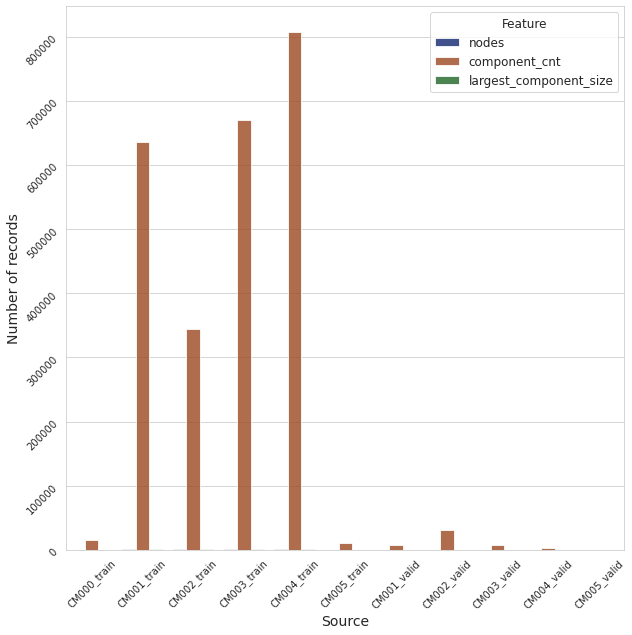

In [86]:
plt.figure(figsize=(10, 10))

source = [f'CM00{i}_train' for i in range(6) for _ in range(3)]
source.extend([f'CM00{i}_valid' for i in range(1,6) for _ in range(3)])
feature_names = [df_3.columns[1], df_3.columns[3], df_3.columns[4]]*11
values = []
for row in df_3.itertuples(False):
    values.extend([*row[1:3], row[4]])

plot_df = pd.DataFrame({"Source": source, "Feature": feature_names, "Value": values})

ax = sns.barplot(
    data=plot_df,
    x="Source",
    y="Value",
    hue="Feature",
    ci="sd",
    palette="dark",
    alpha=0.8
)

plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.xlabel("Source", fontsize=14)
plt.ylabel("Number of records", fontsize=14)

plt.legend(title='Feature', fontsize='large', title_fontsize='large', loc=0)

plt.savefig("./plot/network_size.png", format='png', transparent=True)
plt.show()

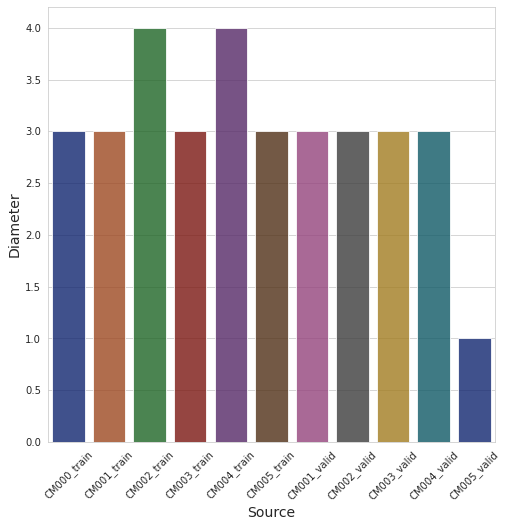

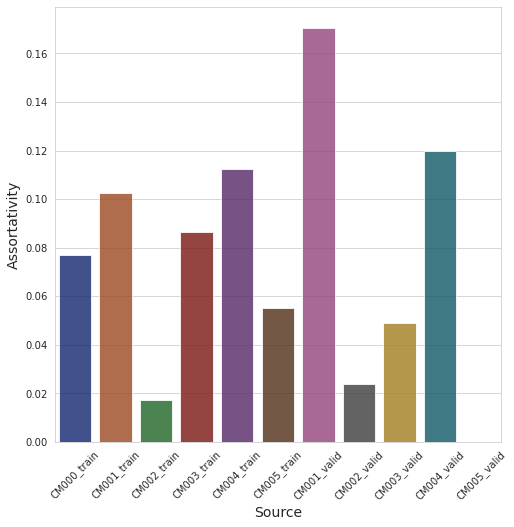

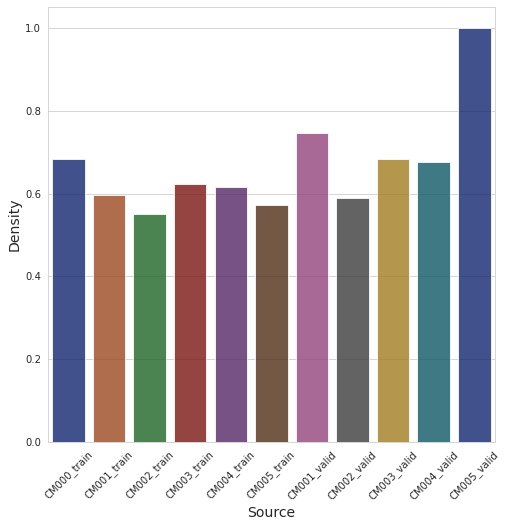

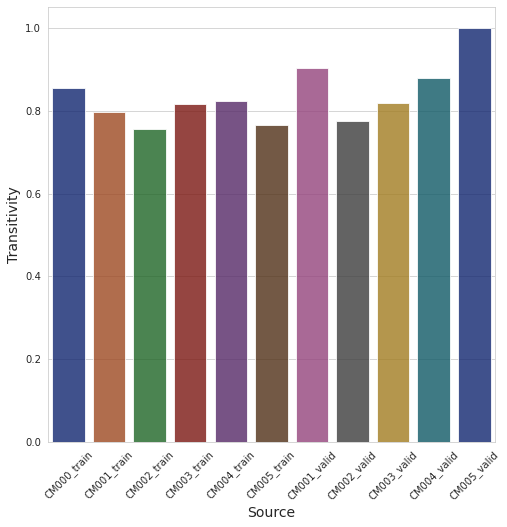

In [101]:
# for diemeter

for col in ['diameter', 'assortativity', 'density', 'transitivity']:
    plt.figure(figsize=(8, 8))
    ax = sns.barplot(
        data=df_3,
        x="source",
        y=col,
        errcolor='gray', 
        errwidth=2,
        ci="sd",
        palette="dark",
        alpha=0.8
    )
    plt.xticks(rotation=45)
    plt.xlabel("Source", fontsize=14)
    plt.ylabel(col.capitalize(), fontsize=14)

    plt.savefig(f'./plot/{col}.png', format='png', transparent=True)
    plt.show()

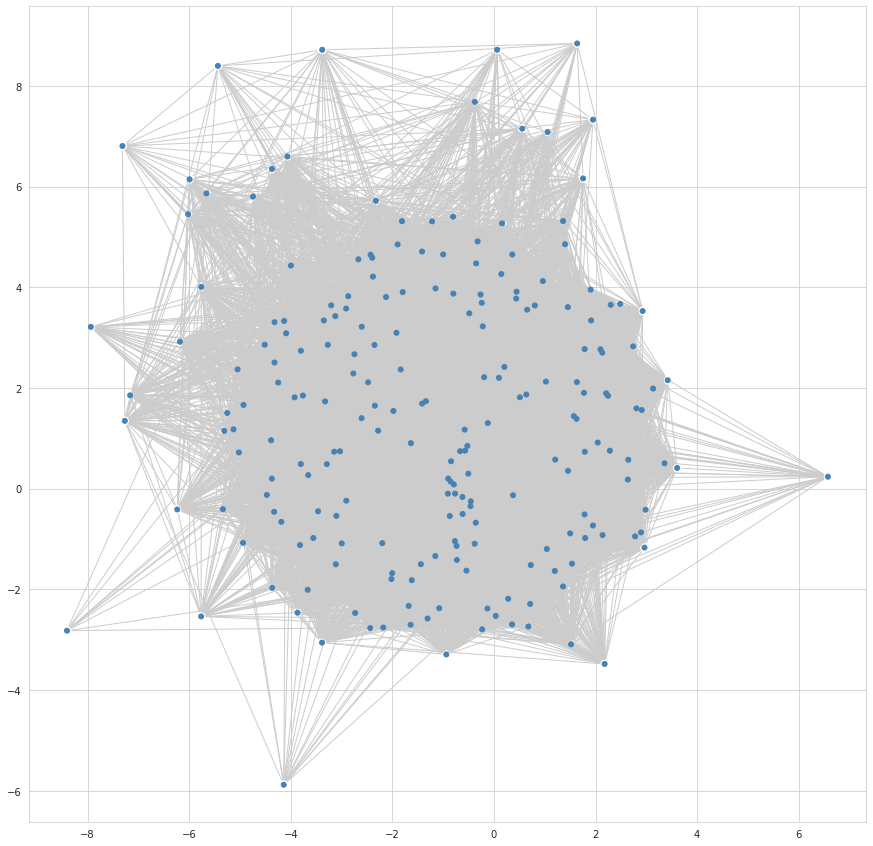

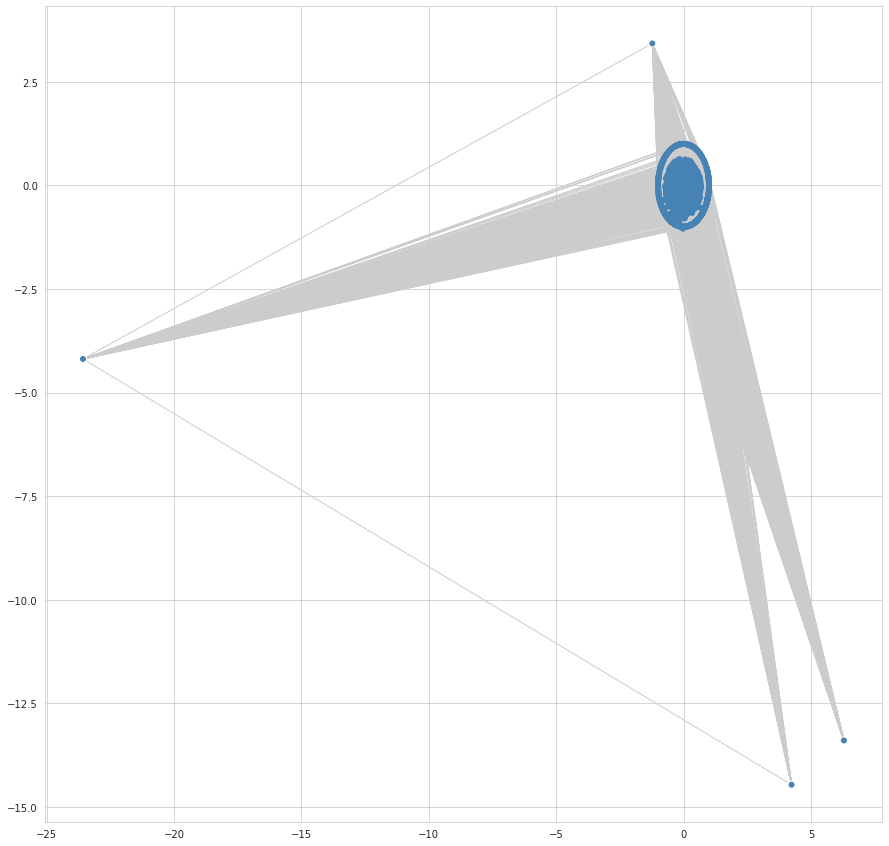

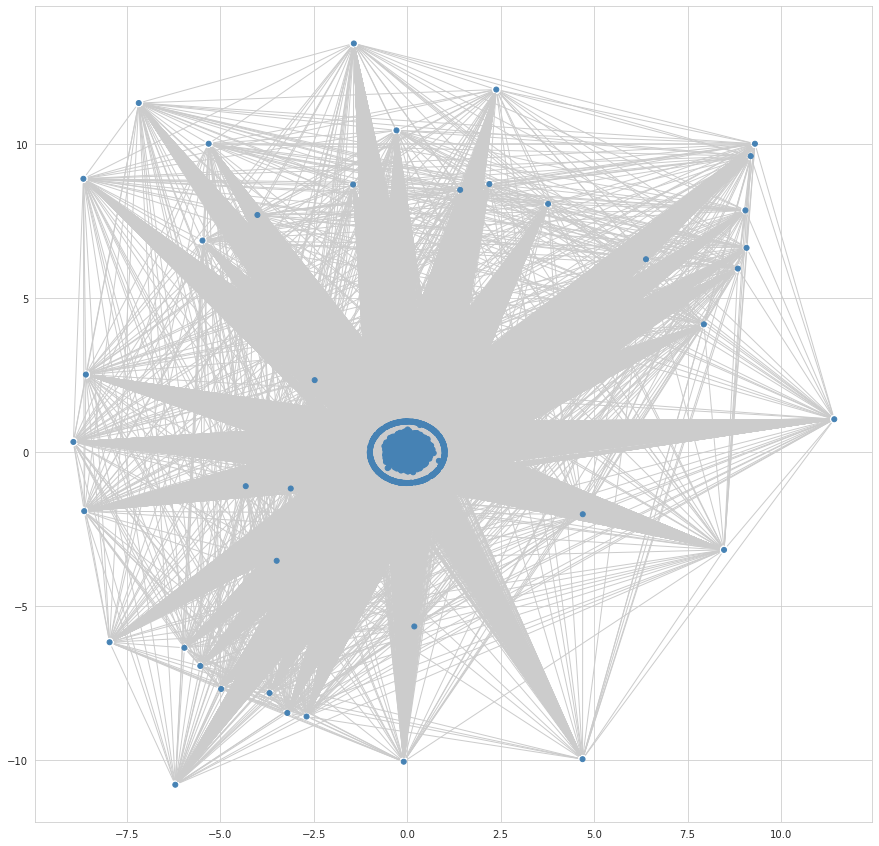

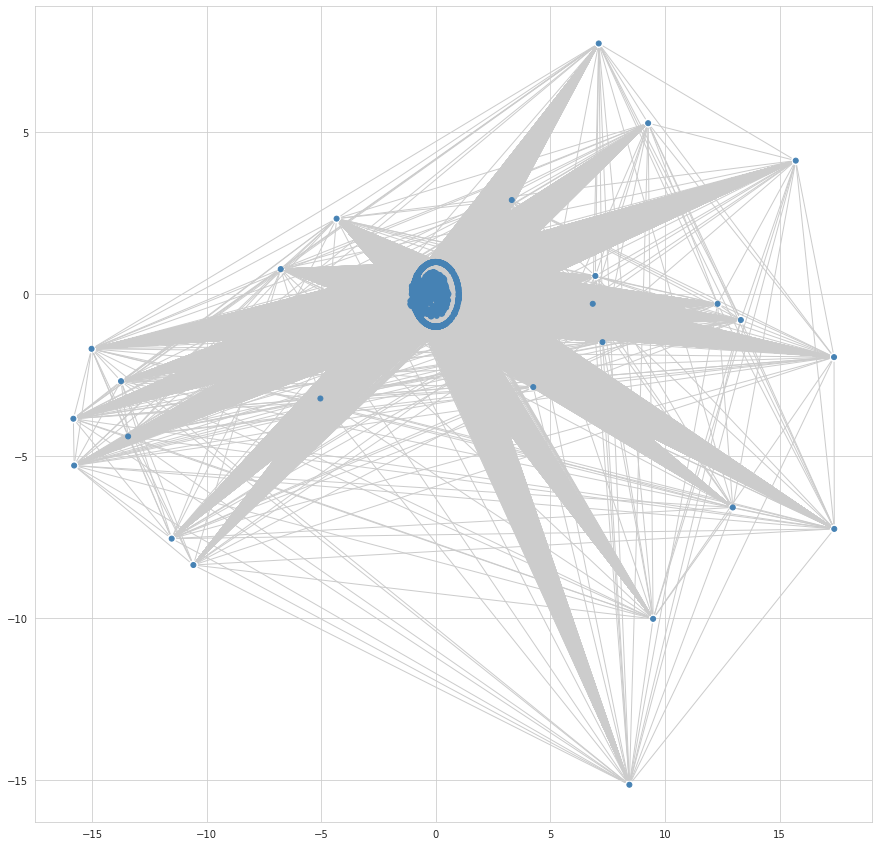

In [ ]:
for label, g in zip(index_labels,gs):
    fig, ax = plt.subplots(figsize=(15, 15))
    layout = g.layout("kamada_kawai")
    ig.plot(g, 
            target=ax,
            layout=layout,
           edge_color='#ccc')
    plt.savefig(f'plot/{label}_graph.png')
    plt.show()

# Degree distribution

In [451]:
degrees = pickle.load(open('imnet_params/degree_statics.pkl', 'rb'))

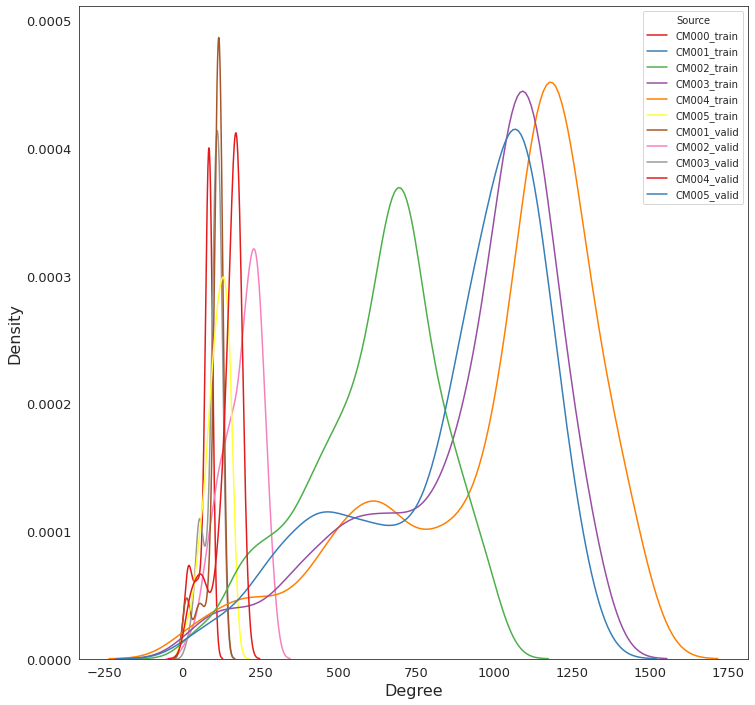

In [292]:
sns.set_style('white')
plt.figure(figsize=(12, 12))
temp_datas = []
for g, source in zip(gs,index_labels):
    for d in g.degree():
        temp_datas.append([source,d])
plot_df = pd.DataFrame(temp_datas,columns=['Source', 'Degree'])
ax = sns.kdeplot(data=plot_df, x='Degree', hue='Source', palette='Set1', warn_singular=False)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Degree', fontsize=16)
plt.ylabel('Density', fontsize=16)

# plt.legend(title='Soucre', title_fontsize='large')
plt.savefig("./plot/degree_distribution.png", format='png', bbox_inches='tight')
plt.show()

In [453]:
def gen_index(start=0, end=5):
    seq=[0,0]
    for a,b in zip(range(start+1,end+1), range(end+1,end*2+1)):
        seq.append(a)
        seq.append(b)
    return seq
gen_index()

[0, 0, 1, 6, 2, 7, 3, 8, 4, 9, 5, 10]

In [458]:
degrees2 = []
for label in index_labels:
    degrees2.append(degrees[label])

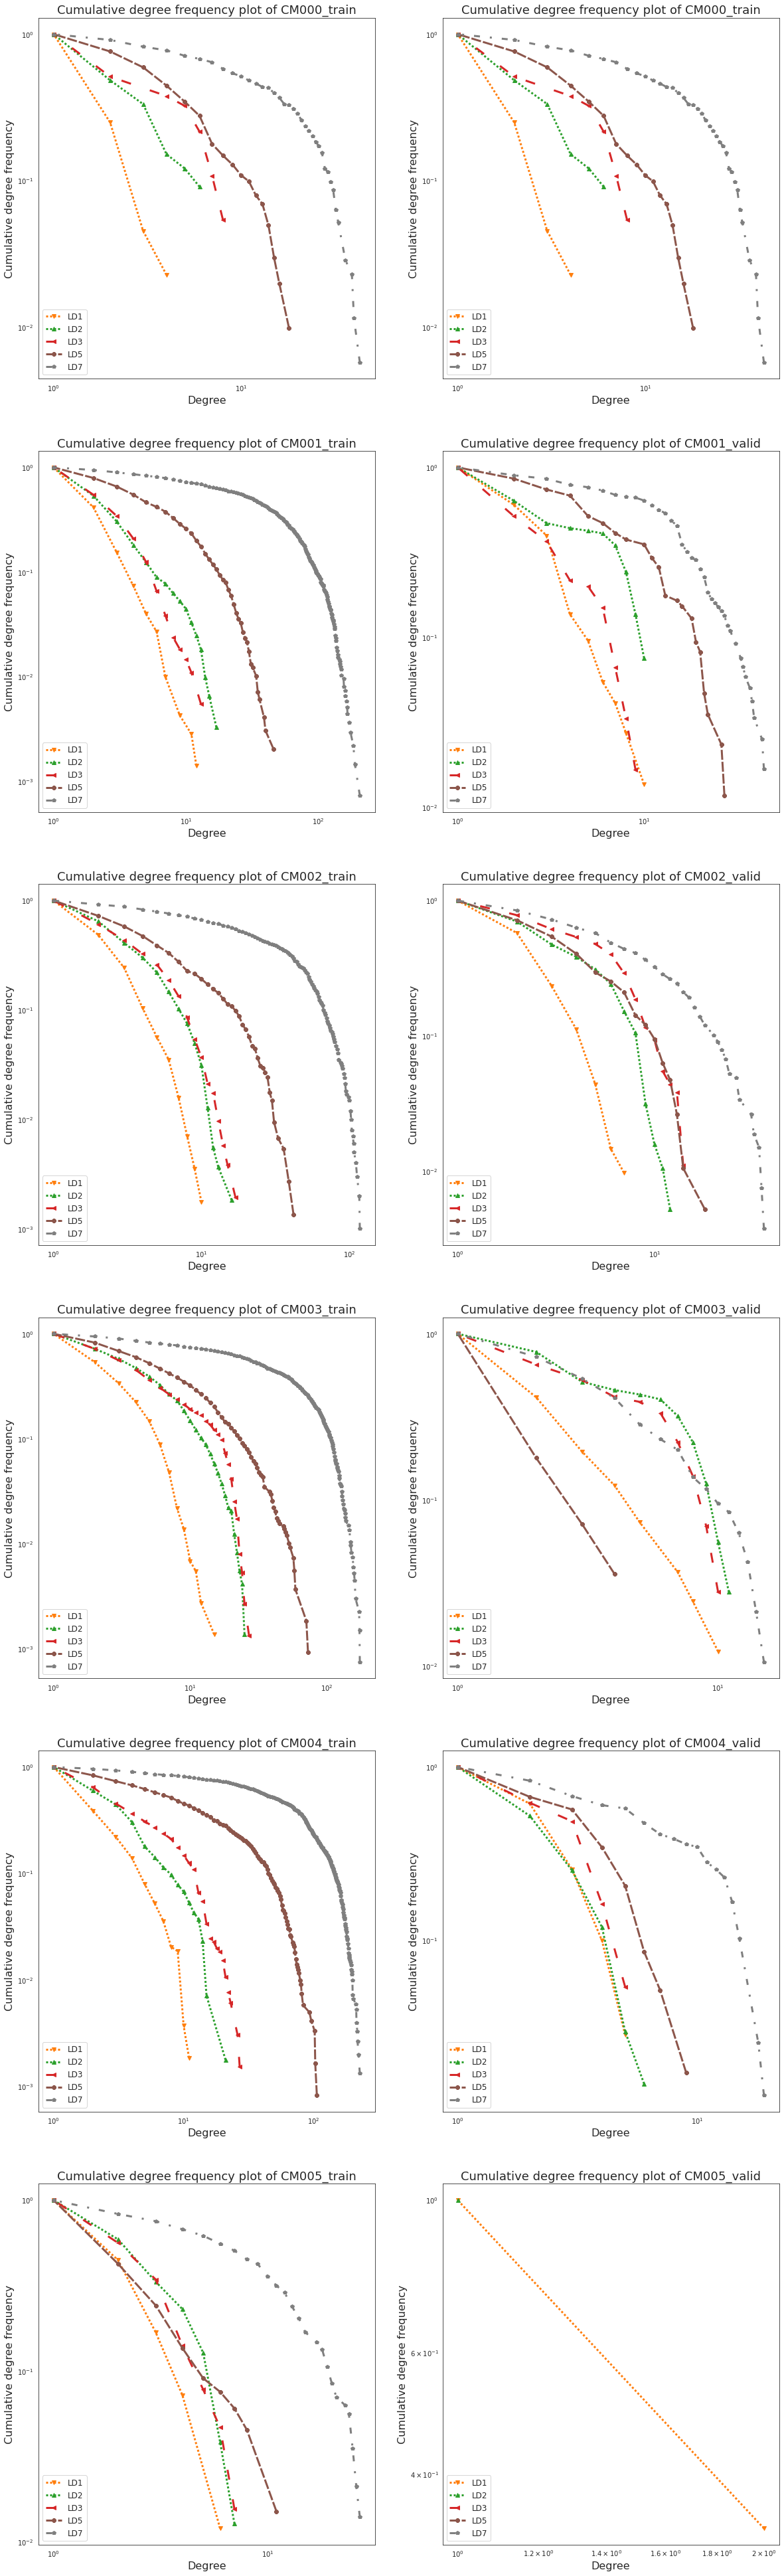

In [460]:
fig, axes = plt.subplots(6, 2, figsize=(20, 70))
axes = axes.flat
custom_lines = [Line2D([0], [0], color=colors[LD], marker=Line2D.filled_markers[LD], ms=6, ls=linestyle_tuple[LD][1], lw=3) for LD in [1,2,3,5,7]]

for ax_idx, data_idx in zip(range(0,12),gen_index(0,5)):
    for LD in [1,2,3,5,7]:
        # degree_sequence = sorted(degrees[data_idx][:, LD], reverse=True)  # degree sequence
        degree_sequence = sorted(degrees2[data_idx][degrees2[data_idx][:,LD]>0, LD], reverse=True)  # degree sequence
        if len(degree_sequence)>0:
            degreeCount = collections.Counter(degree_sequence)
            deg, cnt = zip(*degreeCount.items())
            cnt_frequency = list(map(lambda x: x/sum(cnt), cnt))
            cs = np.cumsum(cnt_frequency)
            axes[ax_idx].loglog(deg, cs, color=colors[LD], marker=Line2D.filled_markers[LD], ms=6, ls=linestyle_tuple[LD][1], lw=3)
    axes[ax_idx].set_ylabel('Cumulative degree frequency', fontsize=16)
    axes[ax_idx].set_xlabel(f'Degree', fontsize=16)
    axes[ax_idx].legend(handles=custom_lines, labels=[f'LD{x}' for x in [1,2,3,5,7]], loc='lower left', fontsize='large', title_fontsize='large')
    axes[ax_idx].set_title(f'Cumulative degree frequency plot of {index_labels[data_idx]}',fontsize=18)
    
plt.savefig(f'plot/cumulative_degree_frequency_without_0.png', format='png', bbox_inches='tight')
plt.show()

Fitted cumulative degree frequency on LD1-layer of CM000_train


sumsquare_error         aic        bic  kl_div
nct               1826.657405  328.091005  30.040972     inf
levy              1844.670922  327.616795  27.307636     inf
invgauss          1851.369702  305.192704  28.708430     inf
norminvgauss      1851.536347  306.730948  30.095084     inf
f                 1890.968073  349.716586  30.179377     inf

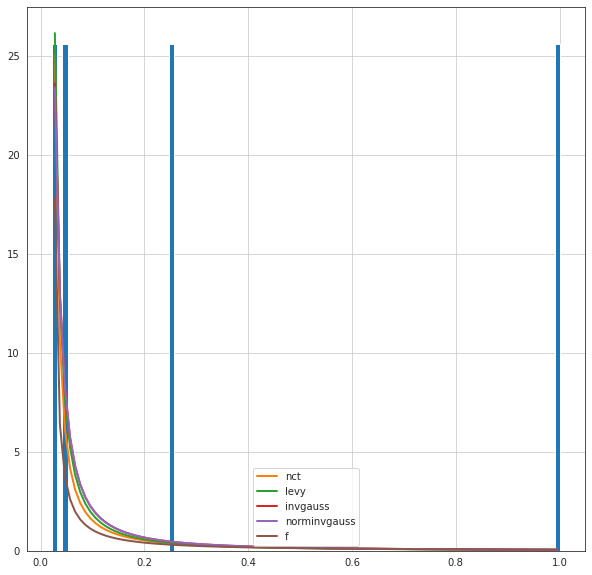

In [468]:
data_idx=0
degree_sequence = sorted(degrees2[data_idx][degrees2[data_idx][:,1]>0, 1], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
cnt_frequency = list(map(lambda x: x/sum(cnt), cnt))
cs = np.cumsum(cnt_frequency)

f = Fitter(data=cs)  # 创建Fitter类
f.fit()  # 调用fit函数拟合分布
print(f'Fitted cumulative degree frequency on LD1-layer of {index_labels[data_idx]}')
f.summary()  # 输出拟合结果

Fitted cumulative degree frequency on LD1-layer of CM001_valid


sumsquare_error         aic        bic  kl_div
levy             695.996309  248.555155  43.527527     inf
genextreme       696.071154  239.355931  45.725720     inf
invweibull       696.078160  239.339819  45.725810     inf
invgauss         699.765743  219.075221  45.773363     inf
invgamma         701.710150  242.415514  45.798336     inf

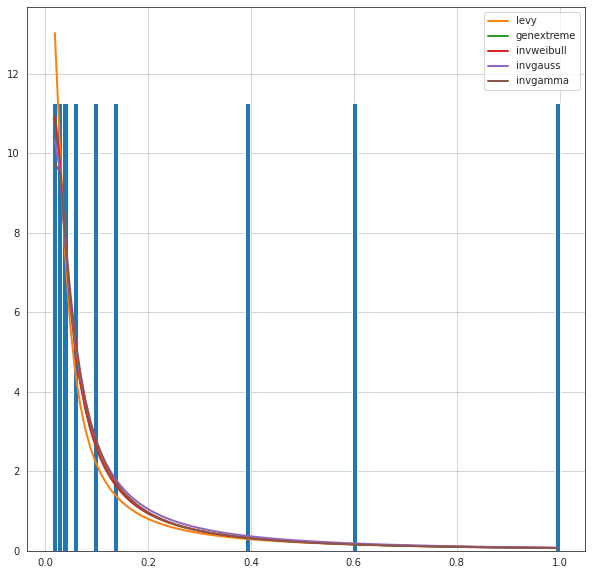

In [469]:
data_idx=6
degree_sequence = sorted(degrees2[data_idx][degrees2[data_idx][:,1]>0, 1], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
cnt_frequency = list(map(lambda x: x/sum(cnt), cnt))
cs = np.cumsum(cnt_frequency)

f = Fitter(data=cs)  # 创建Fitter类
f.fit()  # 调用fit函数拟合分布
print(f'Fitted cumulative degree frequency on LD1-layer of {index_labels[data_idx]}')
f.summary()  # 输出拟合结果

Fitted cumulative degree frequency on LD1-layer of CM002_valid


sumsquare_error         aic        bic  kl_div
exponweib      1067.594525  354.342867  42.974413     inf
gamma          1083.718406  788.586133  41.133433     inf
invgamma       1084.777902  330.118474  41.140273     inf
ncf            1102.813200  357.559980  45.147517     inf
nct            1113.771488  318.927381  43.270820     inf

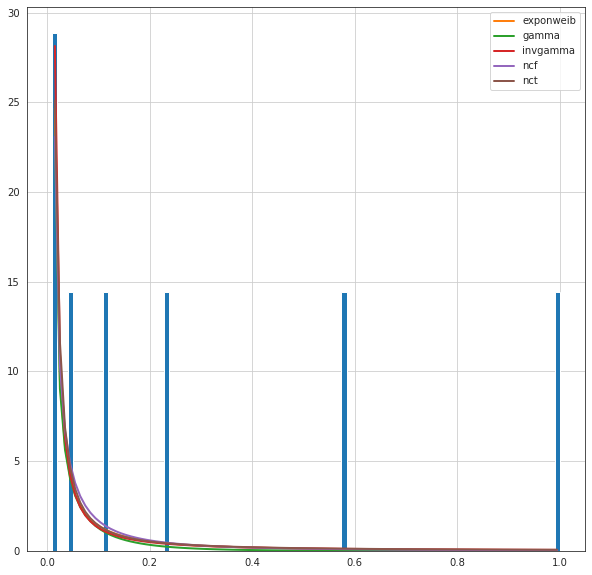

In [470]:
data_idx=7
degree_sequence = sorted(degrees2[data_idx][degrees2[data_idx][:,1]>0, 1], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
cnt_frequency = list(map(lambda x: x/sum(cnt), cnt))
cs = np.cumsum(cnt_frequency)

f = Fitter(data=cs)  # 创建Fitter类
f.fit()  # 调用fit函数拟合分布
print(f'Fitted cumulative degree frequency on LD1-layer of {index_labels[data_idx]}')
f.summary()  # 输出拟合结果

Fitted cumulative degree frequency on LD1-layer of CM003_valid


sumsquare_error         aic        bic  kl_div
genextreme         800.174483  254.814413  43.081431     inf
invweibull         800.176212  254.802418  43.081448     inf
levy               801.529149  262.688224  41.015521     inf
invgauss           804.126638  235.662014  43.120846     inf
norminvgauss       804.584791  238.479650  45.204845     inf

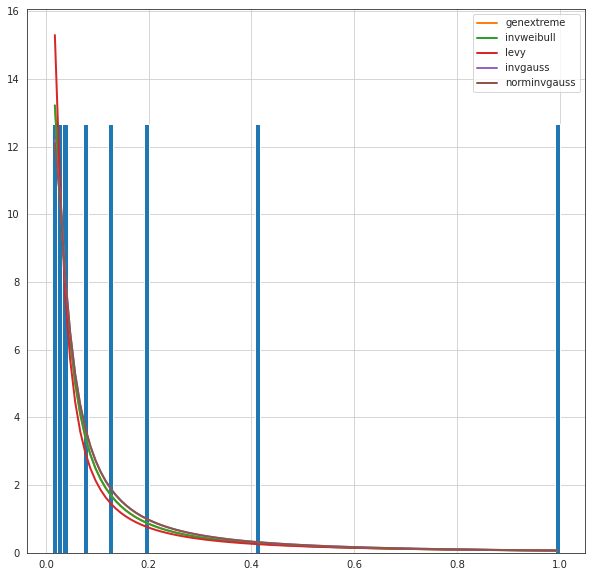

In [471]:
data_idx=8
degree_sequence = sorted(degrees2[data_idx][degrees2[data_idx][:,1]>0, 1], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
cnt_frequency = list(map(lambda x: x/sum(cnt), cnt))
cs = np.cumsum(cnt_frequency)

f = Fitter(data=cs)  # 创建Fitter类
f.fit()  # 调用fit函数拟合分布
print(f'Fitted cumulative degree frequency on LD1-layer of {index_labels[data_idx]}')
f.summary()  # 输出拟合结果

Fitted cumulative degree frequency on LD1-layer of CM004_valid


sumsquare_error         aic        bic  kl_div
lognorm       1714.850666  392.192434  34.016531     inf
ncf           1729.834967  240.875364  37.278906     inf
chi           1734.049207  332.745163  34.072197     inf
burr12        1739.184544  629.914896  35.696420     inf
nakagami      1756.693760  148.384372  34.137068     inf

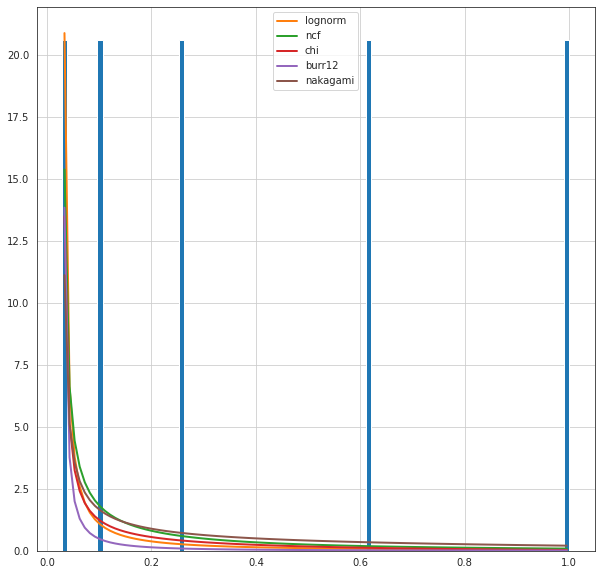

In [472]:
data_idx=9
degree_sequence = sorted(degrees2[data_idx][degrees2[data_idx][:,1]>0, 1], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
cnt_frequency = list(map(lambda x: x/sum(cnt), cnt))
cs = np.cumsum(cnt_frequency)

f = Fitter(data=cs)  # 创建Fitter类
f.fit()  # 调用fit函数拟合分布
print(f'Fitted cumulative degree frequency on LD1-layer of {index_labels[data_idx]}')
f.summary()  # 输出拟合结果

In [510]:
subgraphs = []
for g_idx, g in enumerate(gs):
    edge_ids = {i:[] for i in range(1,13)}
    for edge in g.es:
        edge_ids[edge['weight']].append(edge.index)
    subgraph = []
    for i in range(1,13):
        subgraph.append(g.subgraph_edges(edge_ids[i], delete_vertices=True))
    subgraphs.append(subgraph)

In [519]:
subgraphs[6][0].vcount()

73

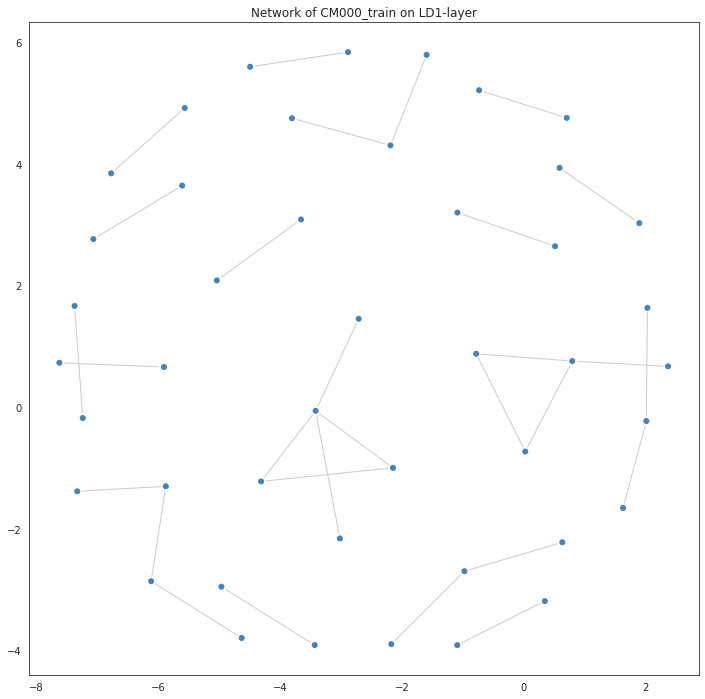

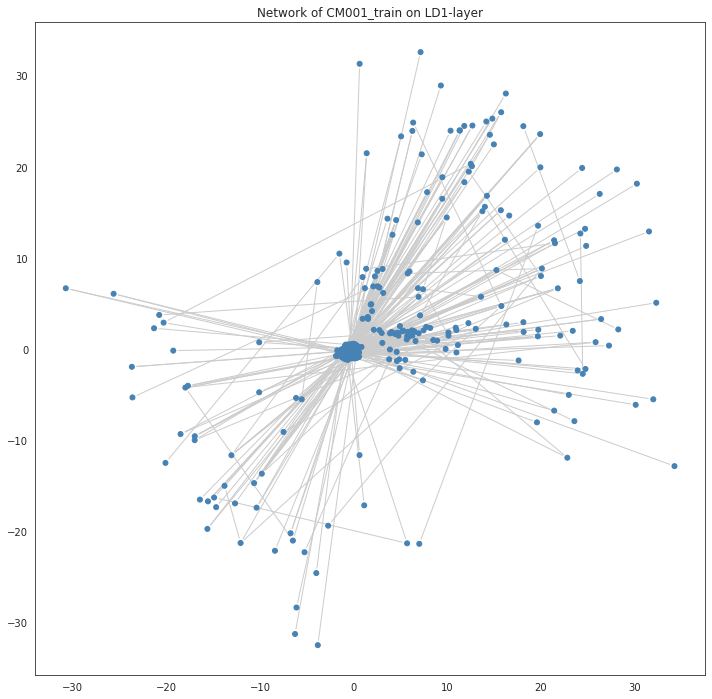

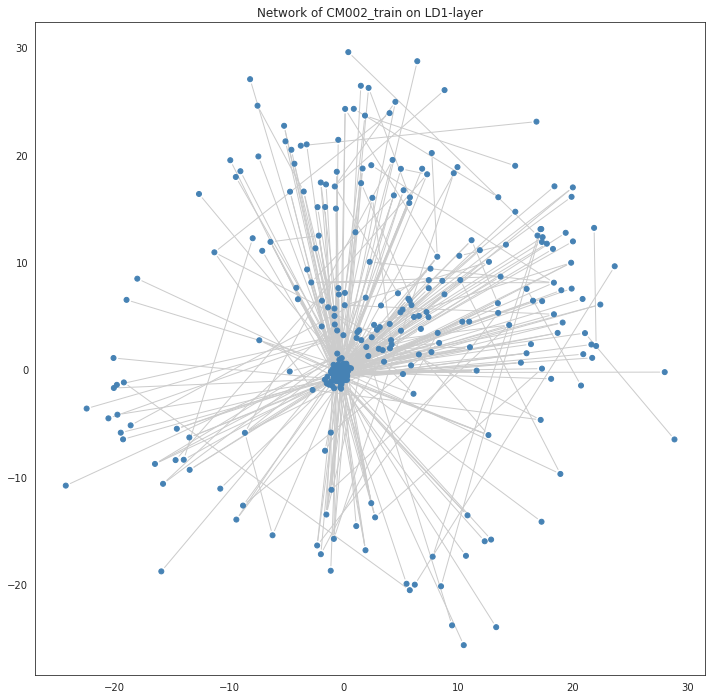

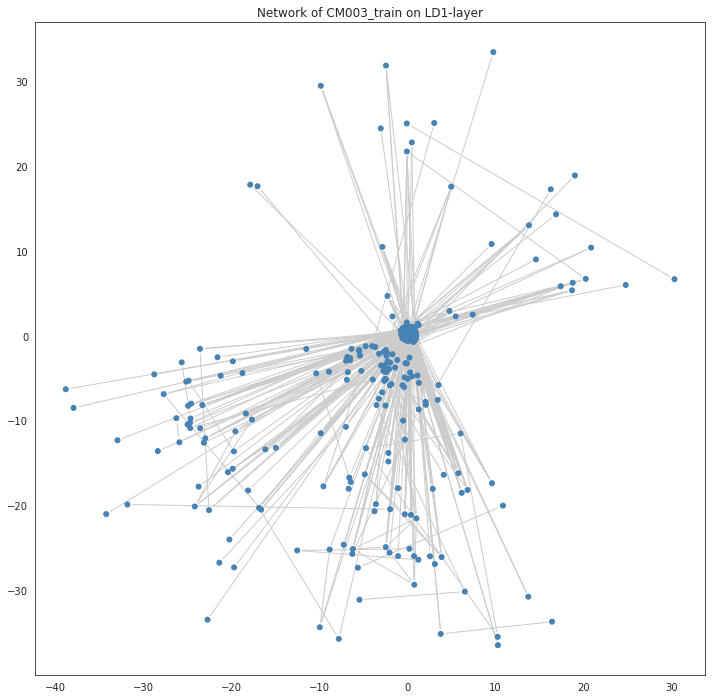

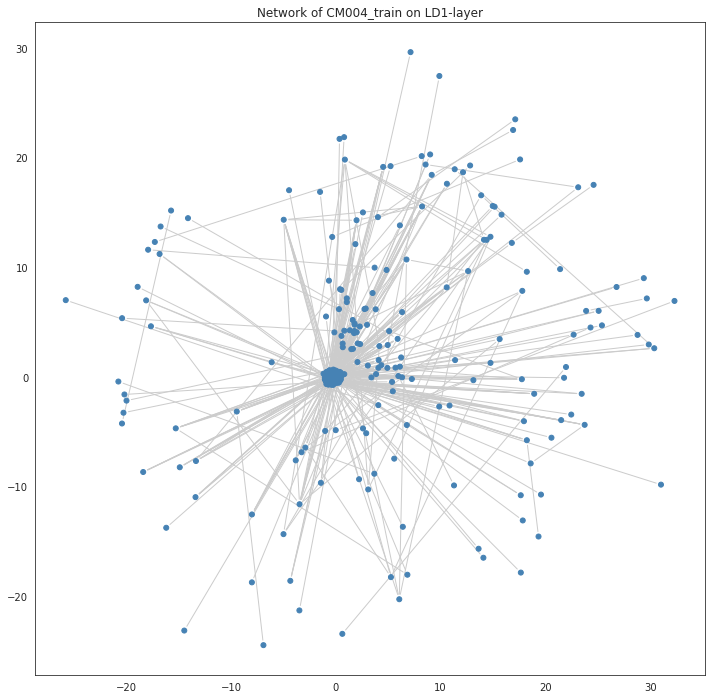

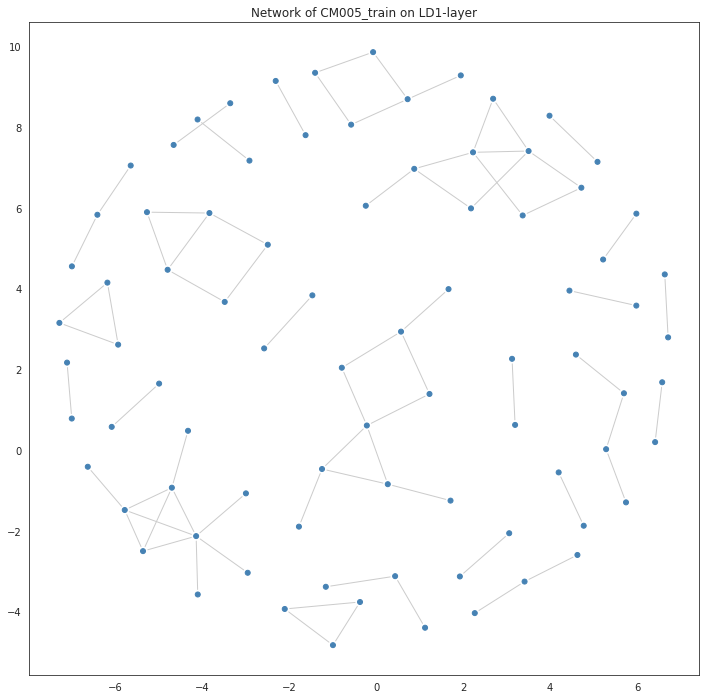

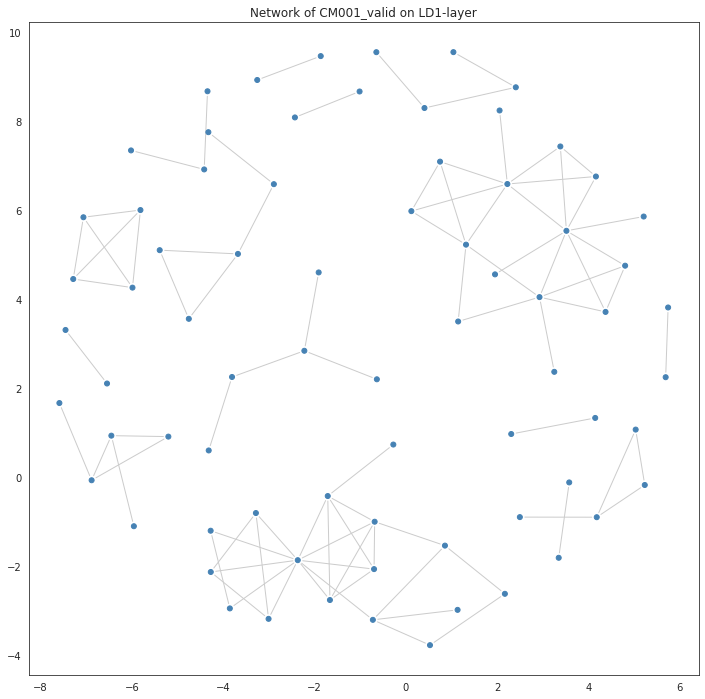

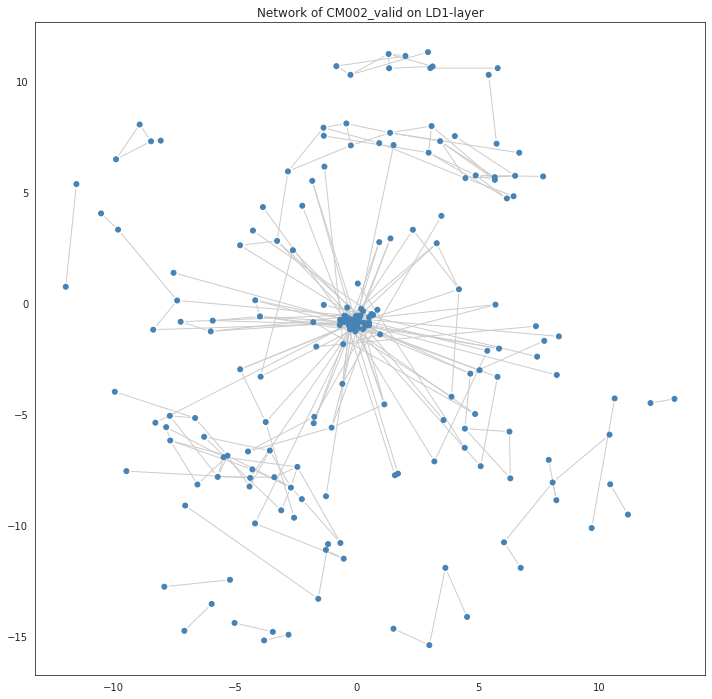

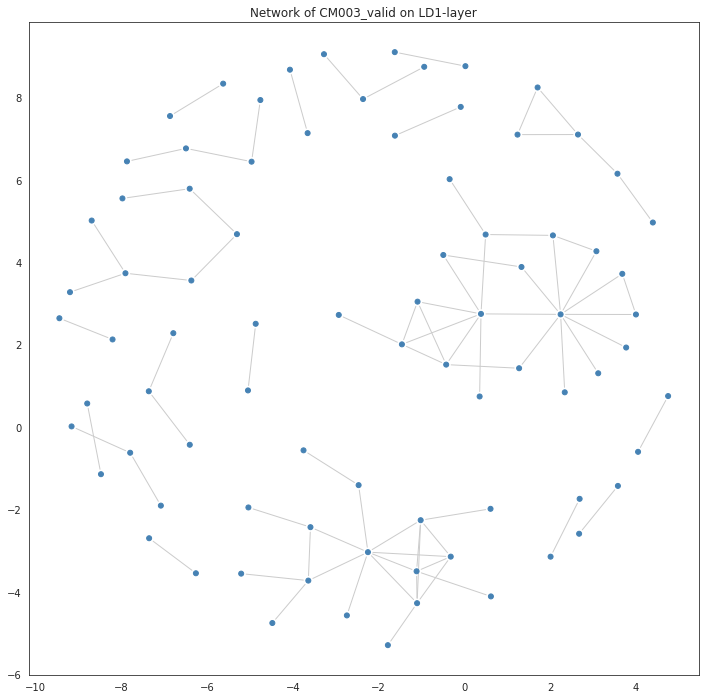

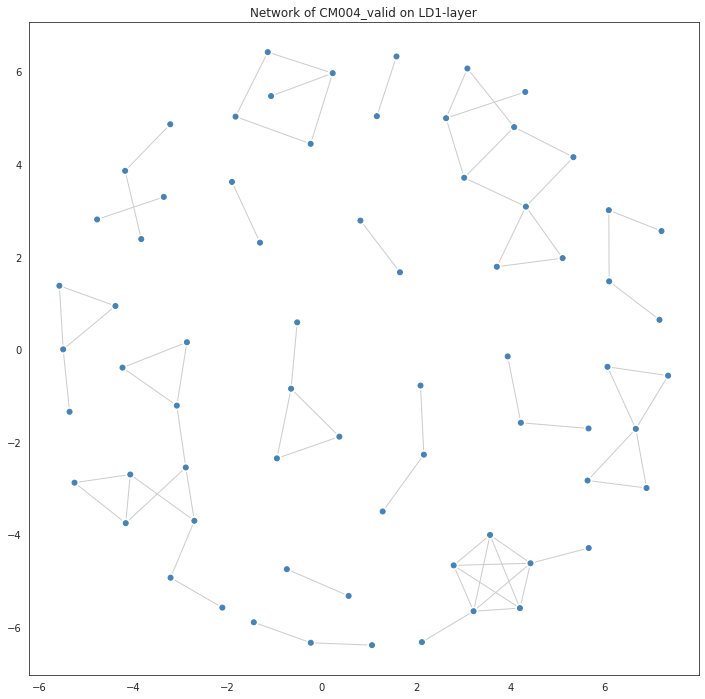

In [520]:
# update edge attribute {'weight'}: from str to int
for subgs in subgraphs:
    for g_LD in subgs:
        e['weight'] = int(e['weight'])

fig, ax = plt.subplots(figsize=(10, 10))
for label, g in zip(index_labels,[subg[0] for subg in subgraphs]):
    
    layout = g.layout("kamada_kawai")
    ig.plot(g, 
            target=ax,
            layout=layout,
           edge_color='#ccc')
    plt.title(f'Network of {label} on LD1-layer')
    # plt.savefig(f'plot/{label}_graph_LD1.png',bbox_inches='tight')
    plt.show()

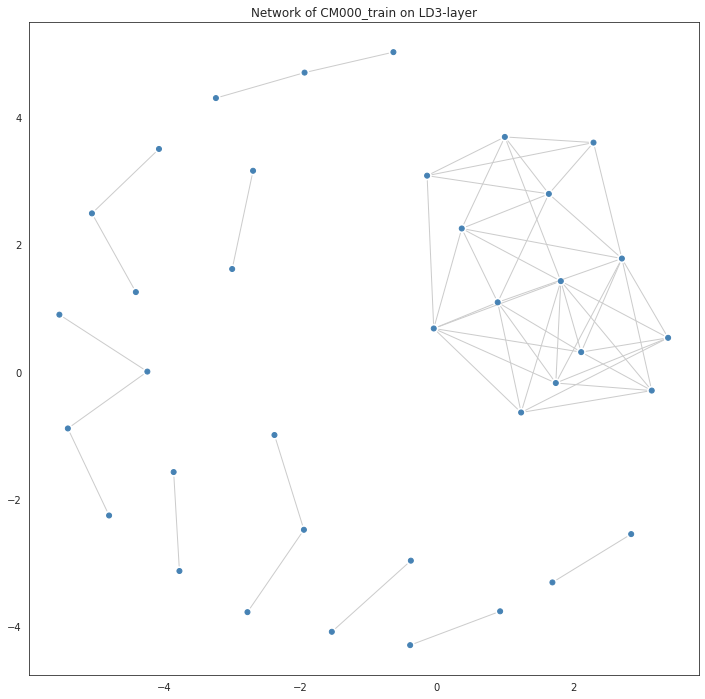

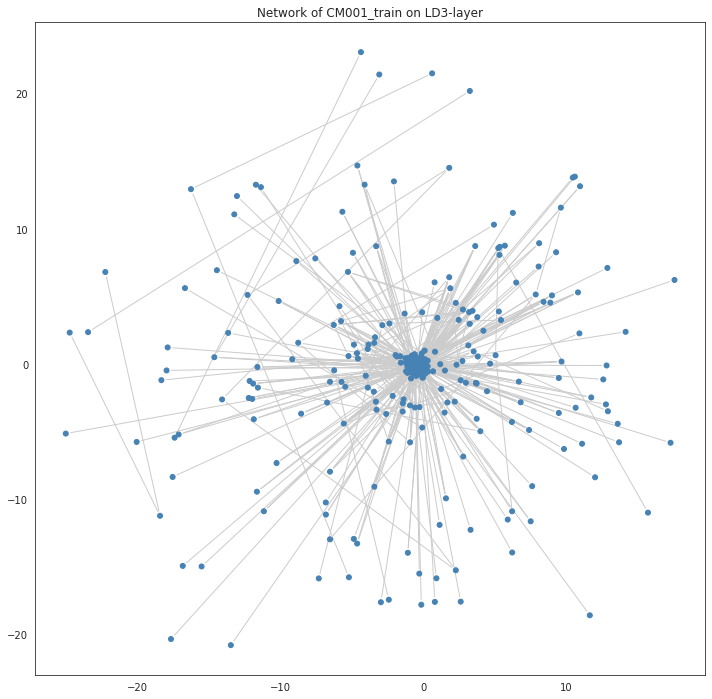

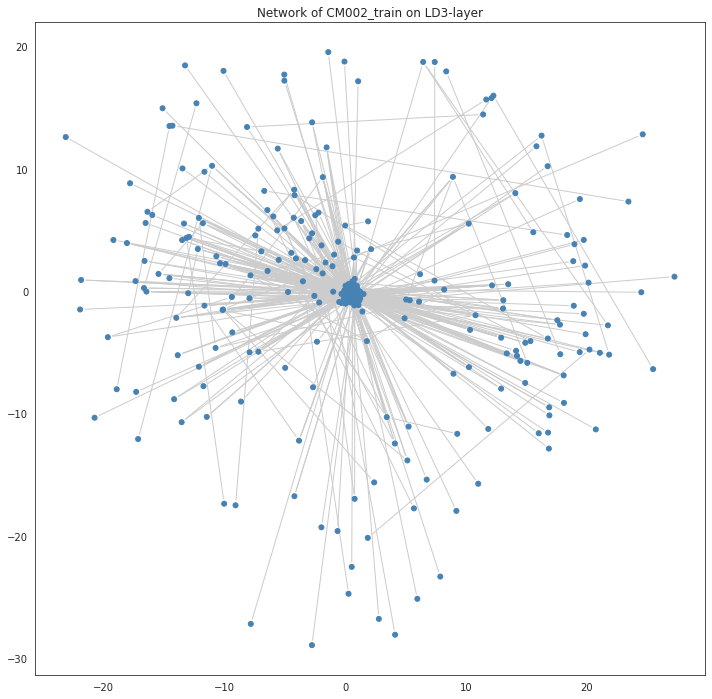

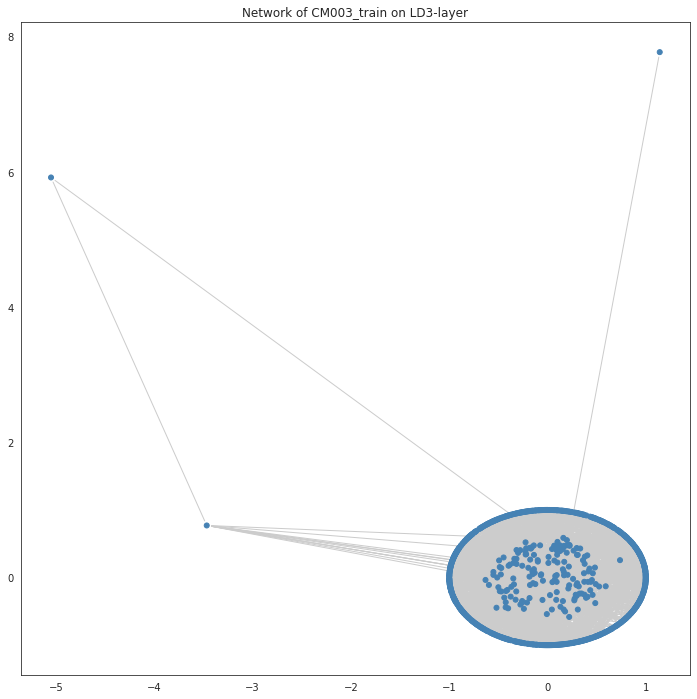

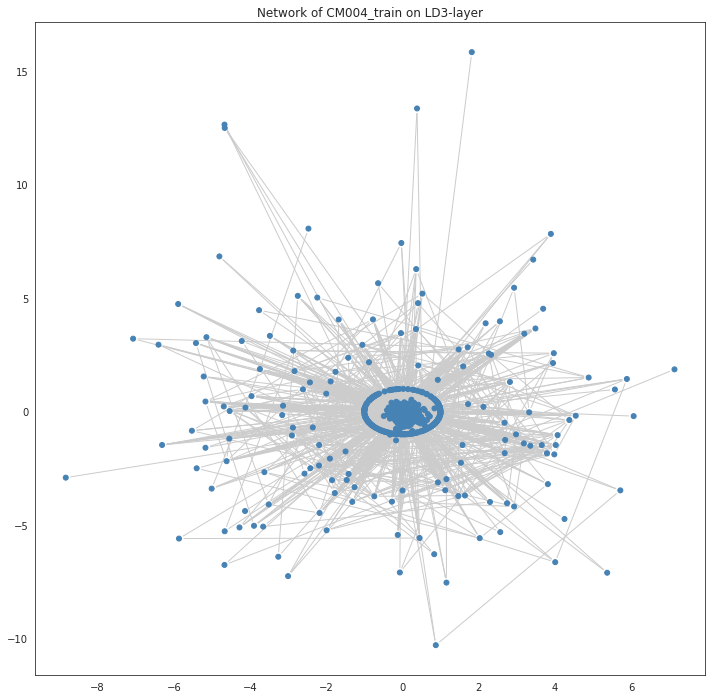

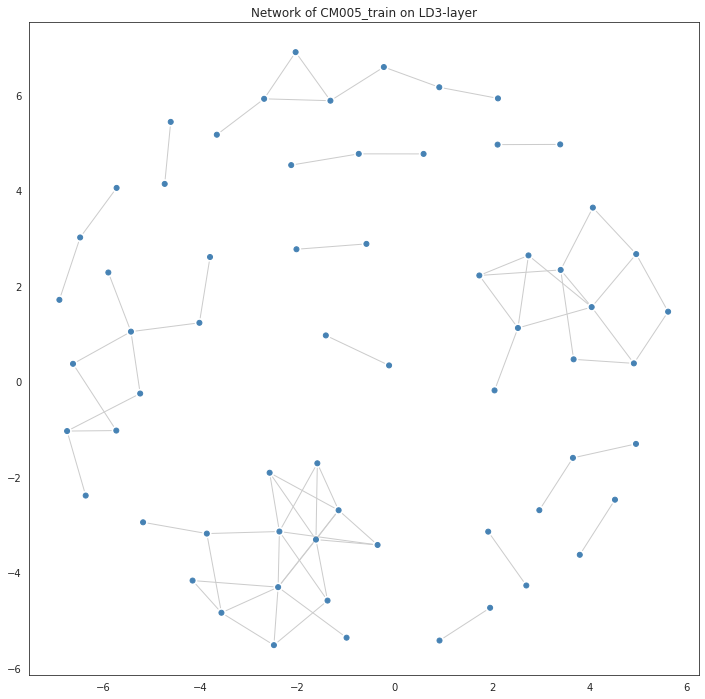

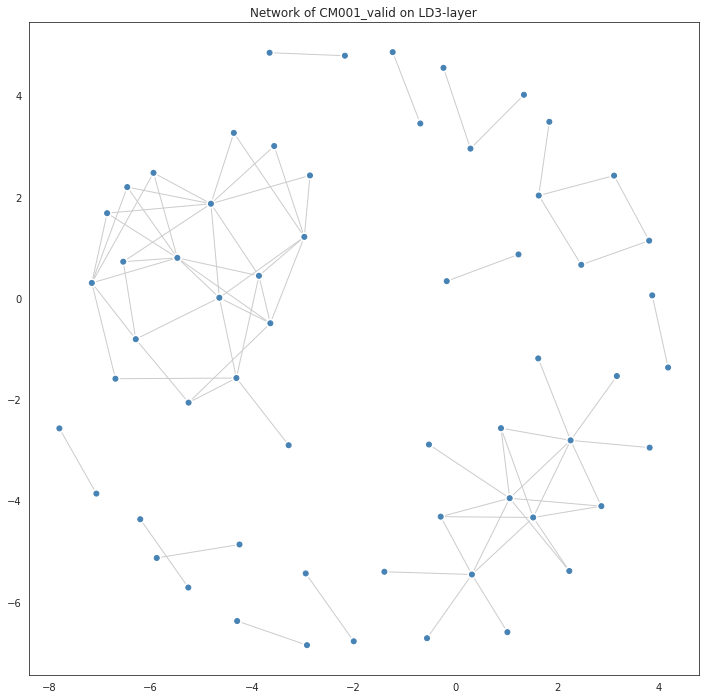

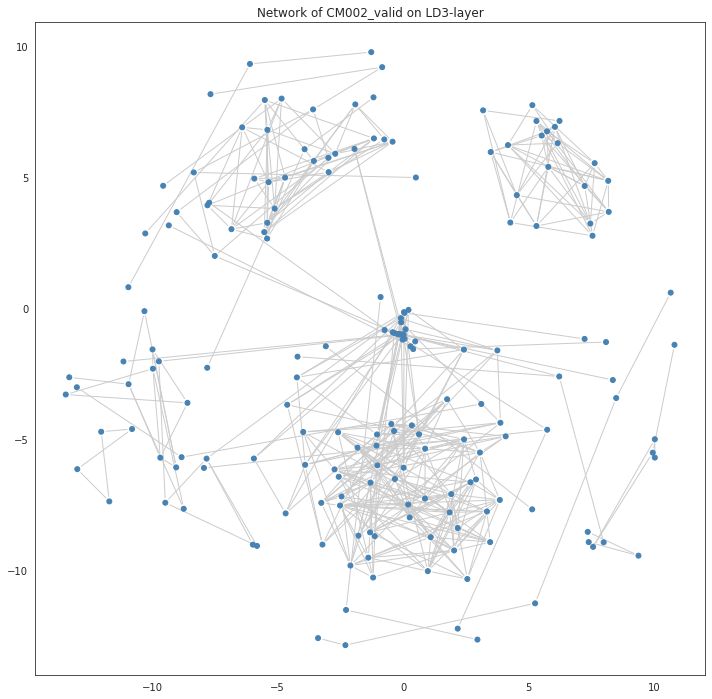

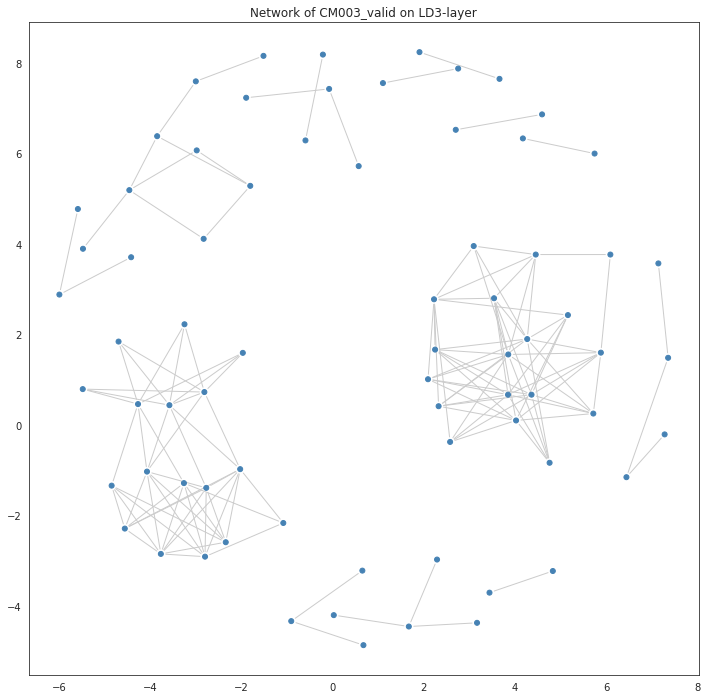

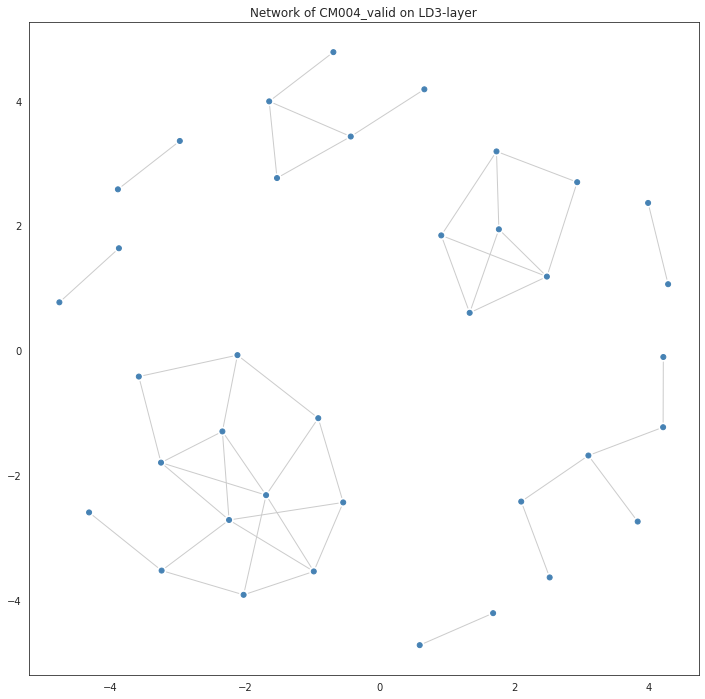

In [502]:
for label, g in zip(index_labels,subgs):
    fig, ax = plt.subplots(figsize=(12, 12))
    layout = g.layout("kamada_kawai")
    ig.plot(g,
            target=ax,
            layout=layout,
           edge_color='#ccc')
    plt.title(f'Network of {label} on LD3-layer')
    plt.savefig(f'plot/{label}_graph_LD3.png',bbox_inches='tight')
    plt.show()

In [ ]:
# 极大团： g.maximal_cliques()
# 最大团（largest clique）：g.largest_cliques()
# 
# g.clique_number()